In [ ]:
%load_ext autoreload
%autoreload 2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import time

from benchmarks.models.idw import run_IDW_benchmark
from benchmarks.models.kriging import kriging_external_drift

from utils.load import *
from utils.visualisation import *
from utils.sampling import stratified_spatial_sampling_dual

from scipy.stats import pearsonr

In [ ]:
config = read_config('config.yaml')

In [3]:
radar_df = load_radar_dataset(folder_name='sg_radar_data')
raingauge_df = load_raingauge_dataset('rainfall_data.csv', N=0)
cml_df = load_cml_dataset('CML_data_processed_2025.nc')
print(radar_df.shape)
print(raingauge_df.shape)
print(cml_df.shape)

The size of dataset is 8334
(8334, 5)
(26096, 63)
(6991632, 27)


# Load station split and process rain gauge stations

In [4]:
station_dict = get_station_coordinate_mappings()
station_split = stratified_spatial_sampling_dual(station_dict, seed=123, plot=False)

training_stations=station_split['statistical']['train']
test_stations=station_split['statistical']['test']

#Rain gauge choices: Resample either to 5 or 15 minute intervals
raingauge_df_5mins = raingauge_df.mul(12)
raingauge_df_15mins = raingauge_df.resample('15min').mean().mul(12) #resamples to 15 mins and converts to mm/hour rainfall rate

raingauge_choice_df = raingauge_df_15mins

K-MEANS STRATIFIED SPATIAL SAMPLING
Total stations: 63
Number of clusters: 8
Random seed: 123

Split configuration:
  - Test (shared): 10%
  - Statistical train: 90%
  - ML train: 70%
  - ML validation: 20%

STEP 1: K-means Clustering
Clustering complete. Cluster centers:
  Cluster 0: (103.8761, 1.3289) - 12 stations
  Cluster 1: (103.7211, 1.3533) - 7 stations
  Cluster 2: (103.9656, 1.3530) - 9 stations
  Cluster 3: (103.6487, 1.2749) - 2 stations
  Cluster 4: (103.8192, 1.2958) - 9 stations
  Cluster 5: (103.8591, 1.3867) - 9 stations
  Cluster 6: (103.7713, 1.2871) - 8 stations
  Cluster 7: (103.7632, 1.4335) - 7 stations

STEP 2: Creating Shared Test Set (10%)
  Cluster 0: 12 stations → 1 test, 11 remaining
  Cluster 1: 7 stations → 1 test, 6 remaining
  Cluster 2: 9 stations → 1 test, 8 remaining
  Cluster 3: 2 stations → 0 test, 2 remaining
  Cluster 4: 9 stations → 1 test, 8 remaining
  Cluster 5: 9 stations → 1 test, 8 remaining
  Cluster 6: 8 stations → 1 test, 7 remaining
  

# IDW Interpolation with rain gauge
Interpolation was conducted with both rain gauge sampling done at 5 minute and 15 minute intervals

In [ ]:
gridx = np.arange(103.605, 104.1, 0.01)
gridy = np.arange(1.145, 1.51, 0.01)
gridy = gridy[::-1] #invert the y-axis to correspond with correct orientation of map output

fig, ax = plt.subplots(3,3, sharex=True, sharey=True, figsize=(10,10))

#With plotting
idw_RMSE = run_IDW_benchmark(raingauge_choice_df,
                             coordinates=station_dict,
                             training_stations=training_stations,
                             test_stations=test_stations,
                             power=2, 
                             loss_hist=False,
                             x_grid=gridx, 
                             y_grid=gridy, 
                             ax=ax,
                             axis_cols=3,
                             axis_rows=3,
                             plot_time_start=pd.Timestamp("2025-02-05 04:15:00"),
                             n_nearest=15,
                             regression_plot=True
                             )


# #Without plotting
# idw_RMSE = run_IDW_benchmark(raingauge_choice_df,
#                              coordinates=station_dict,
#                              training_stations=training_stations,
#                              validation_stations=validation_stations,
#                              power=2, 
#                              loss_hist=False,
#                              x_grid=gridx, 
#                              y_grid=gridy,
#                              n_nearest=5
#                              )
for idx, axi in enumerate(ax.flatten()):
  visualise_singapore_outline(ax = axi)

In [5]:
#need to merge radar data with rain gauge data for KED

merged_df_KED = pd.merge(raingauge_choice_df, radar_df, on='time_sgt')
merged_df = raingauge_choice_df

# Kriging interpolation with rain gauge

100%|██████████| 8334/8334 [00:35<00:00, 235.51it/s]


invalid kriges: 6215
final average loss: 0.4288527726743473
Time taken = 35.3897168636322


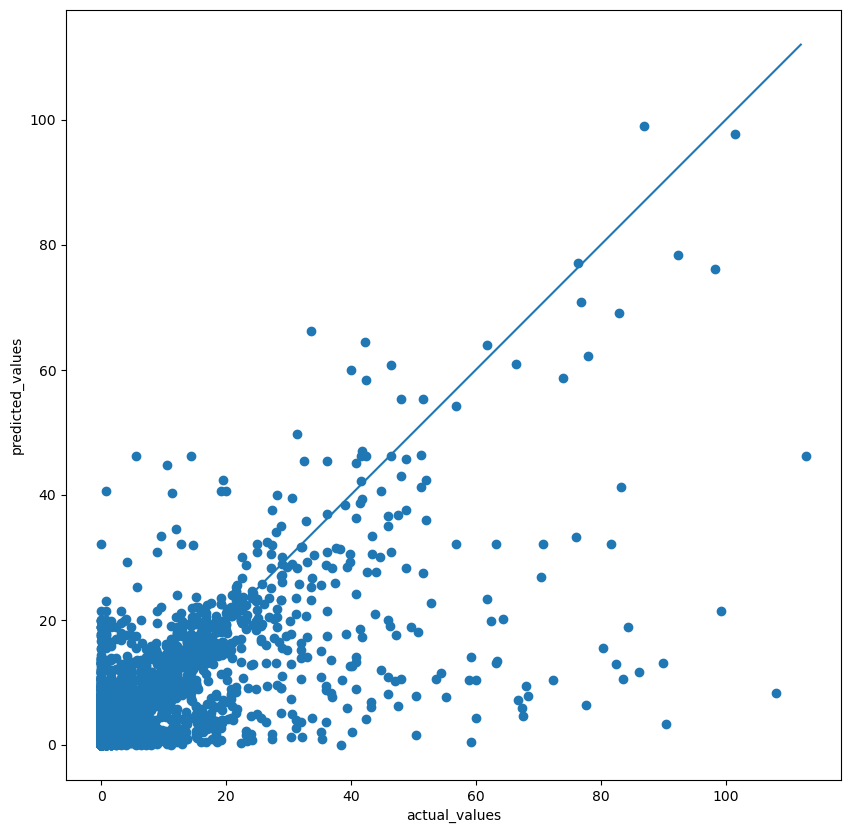

Pearson correlation: 0.7648594543423117


In [19]:
from matplotlib.colors import LogNorm

invalid_kriges = 0
training_ratio = config['dataset_parameters']['train_size']
station_names = []

for key in station_dict.keys():
  station_names.append(key,)

actual_values_arr = np.zeros(shape=[merged_df.shape[0], len(test_stations)])
predicted_values_arr = np.zeros(shape=[merged_df.shape[0], len(test_stations)])

start = time.time()

for idx in tqdm(range(len(merged_df_KED))):
  df = merged_df_KED.iloc[idx]

  kriging_result, kriging_variance = kriging_external_drift(df=df, 
                                                            station_names=training_stations, 
                                                            station_dict=station_dict, 
                                                            variogram_model='exponential', 
                                                            method='ordinary')

  if kriging_result is None:
    invalid_kriges += 1
    continue

    
  row_predicted_arr = []
  row_actual_arr = []
  
  #Calculate loss
  for test_station in test_stations:
    if not np.isnan(df[test_station]):
      rain_gauge_value = df[test_station]
      lat, lon = station_dict[test_station]
      row = math.floor((1.51 - lat) / 0.01)
      col = math.floor((lon - 103.6) / 0.01)
      kriged_value = kriging_result[row][col]

      row_actual_arr.append(rain_gauge_value)
      row_predicted_arr.append(max(0, kriged_value)) ## Kriged values can be negative and thus we need to account for this and set neg values to 0
    else:
      row_actual_arr.append(np.nan)
      row_predicted_arr.append(np.nan)
    
  actual_values_arr[idx] = np.array(row_actual_arr)
  predicted_values_arr[idx] = np.array(row_predicted_arr)



end = time.time()
MSE_arr = []

assert(len(actual_values_arr) == len(predicted_values_arr))

#calculate loss
for i in range(len(actual_values_arr)):
  pred = predicted_values_arr[i]
  act = actual_values_arr[i]
  mask = ~np.isnan(act)
  MSE = np.mean((pred[mask] - act[mask]) ** 2)
  MSE_arr.append(MSE)

average_RMSE_loss = np.sum(np.sqrt(np.array(MSE_arr))) / len(merged_df)
average_MSE_loss = np.sum(np.array(MSE_arr)) / len(merged_df)

print(f"invalid kriges: {invalid_kriges}")
print(f"final average loss: {average_RMSE_loss}")
#print(f"final average loss (0 rain = 0 loss): {total_RMSE_loss / (len(raingauge_choice_df))}")
print(f"Time taken = {end - start}")


plt.figure(figsize=(10,10))
actual = np.array(actual_values_arr).flatten()
predicted = np.array(predicted_values_arr).flatten()
mask = ~np.isnan(actual)

# plt.hist2d(x=actual[mask], y=predicted[mask],
#                   bins=100, 
#                   cmap='jet',
#                   cmin=1,
#                   norm=LogNorm(vmin=1, vmax=None))
plt.scatter(x=actual, y=predicted)

plot_bound = max(np.nanmax(actual).astype(int),np.nanmax(predicted).astype(int))
plt.plot(np.linspace(0,plot_bound,100),
        np.linspace(0,plot_bound,100))
plt.xlabel('actual_values')
plt.ylabel('predicted_values')
plt.show()


pearson_correlation, _ = pearsonr(actual[mask], predicted[mask])
print(f"Pearson correlation: {pearson_correlation}")
